## Run the following setup code


In [1]:
# Parameters
test_size = 100
num_tables_per_setting = 50
replace_runs = False  # whether to replace existing runs

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import torch
import random
from dotenv import load_dotenv
import os
import sys
from utils import *

sys.path.append("..")
load_dotenv(override=True)

warnings.filterwarnings("ignore")  # ignore warnings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Set seeds for reproducibility
seed = 82718
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Load the polynomial dataset and required functions
%autoreload 2
from benchmarks import PolynomialDataset


def get_datasets(
    sample_size: int,
    x_dim: int,
    test_size: int = test_size,
    n_tables: int = num_tables_per_setting,
):
    effective_sample_size = sample_size + test_size
    test_ratio = test_size / effective_sample_size
    datasets = PolynomialDataset(
        n_tables=n_tables,
        n_samples=effective_sample_size,
        test_ratio=test_ratio,
        x_dim_dist=lambda: x_dim,
        seed=42,
    )
    return datasets

In [4]:
# the effect of sample size on the performance of the methods

sample_size_ablation_path = os.path.join(os.environ["OUTPUT_DIR"], "ablation/sample_size/")
os.makedirs(sample_size_ablation_path, exist_ok=True)

NUM_SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 5000, 10000]
X_DIM = 10

sample_size_datasets = {
    f"polynomial_{sample_size}": get_datasets(
        sample_size=sample_size,
        x_dim=X_DIM,
        test_size=test_size,
        n_tables=num_tables_per_setting,
    )
    for sample_size in NUM_SAMPLES
}

# the effect of feature size on the performance of the methods

feature_size_ablation_path = os.path.join(os.environ["OUTPUT_DIR"], "ablation/feature_size/")
os.makedirs(feature_size_ablation_path, exist_ok=True)

NUM_SAMPLES = 1000
X_DIMS = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

feature_size_datasets = {
    f"polynomial_features_{x_dim}": get_datasets(
        sample_size=NUM_SAMPLES,
        x_dim=x_dim,
        test_size=test_size,
        n_tables=num_tables_per_setting,
    )
    for x_dim in X_DIMS
}

## The Effect of Sample Size and Feature Size on Performance

### CausalPFN

In [ ]:
from src.causalpfn import CATEEstimator, calculate_pehe
from tqdm import tqdm

for datasets, path in zip(
    [sample_size_datasets, feature_size_datasets],
    [sample_size_ablation_path, feature_size_ablation_path],
):
    pbar = tqdm(
        total=sum([len(dataset) for dataset in datasets.values()]),
        desc="CausalPFN",
    )
    for dataset_name, dataset in datasets.items():
        pbar.set_postfix(dataset=dataset_name)
        for i in range(len(dataset)):
            with result_saver(
                dataset_name=dataset_name,
                method_name="CausalPFN",
                all_method_patterns="*",
                all_datasets_patterns="*",
                idx=i,
                artifact_dir=path,
                replace=replace_runs,
            ) as result:
                if result is not None:
                    cate_dset, ate_dset = dataset[i]

                    # CATE
                    cate_estimator = CATEEstimator(
                        device=device,
                    )
                    cate_estimator.fit(cate_dset.X_train, cate_dset.t_train, cate_dset.y_train)
                    estimated_cate = cate_estimator.estimate_cate(X=cate_dset.X_test)
                    pehe = calculate_pehe(cate_pred=estimated_cate, cate_true=cate_dset.true_cate)
                    result["pehe"] = pehe

                pbar.update(1)
    pbar.close()

### Baselines

In [ ]:
from src.causalpfn import calculate_pehe
from tqdm import tqdm

# Baselines (Base)
from benchmarks.baselines import BaselineModel

# Baselines (EconML)
from benchmarks.baselines import (
    TLearnerBaseline,
    SLearnerBaseline,
    XLearnerBaseline,
    DALearnerBaseline,
)


baselines = {
    "T Learner (no HPO)": TLearnerBaseline(hpo=False),
    "S Learner (no HPO)": SLearnerBaseline(hpo=False),
    "X Learner (no HPO)": XLearnerBaseline(hpo=False),
    "DA Learner (no HPO)": DALearnerBaseline(hpo=False),
}

for datasets, path in zip(
    [sample_size_datasets, feature_size_datasets],
    [sample_size_ablation_path, feature_size_ablation_path],
):

    pbar = tqdm(
        total=sum([len(dataset) * len(baselines) for dataset in datasets.values()]),
        desc="Baselines",
    )

    for dataset_name, dataset in datasets.items():
        for baseline_name, baseline in baselines.items():
            pbar.set_postfix(dataset=dataset_name, baseline=baseline_name)
            for i in range(len(dataset)):
                with result_saver(
                    dataset_name=dataset_name,
                    method_name=baseline_name,
                    all_method_patterns="*",
                    all_datasets_patterns="*",
                    idx=i,
                    artifact_dir=path,
                    replace=replace_runs,
                ) as result:
                    if result is not None:
                        baseline: BaselineModel
                        cate_dset, ate_dset = dataset[i]

                        # CATE
                        cate_pred = baseline.estimate_cate(
                            X_train=cate_dset.X_train,
                            t_train=cate_dset.t_train,
                            y_train=cate_dset.y_train,
                            X_test=cate_dset.X_test,
                        )
                        pehe = calculate_pehe(cate_true=cate_dset.true_cate, cate_pred=cate_pred)
                        result["pehe"] = pehe

                    pbar.update(1)
    pbar.close()

### The Effect of Feature Size on CausalPFN's Performance

In [7]:
import pandas as pd

methods_to_show = ["CausalPFN"] + list(baselines.keys())
results_df = pd.DataFrame(columns=["dataset", "method", "pehe", "realization"])
for dataset_name, dataset in sample_size_datasets.items():
    dset_result = load_all_results(dataset_name, sample_size_ablation_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["pehe"])
        for fold_idx in range(num_realizations):
            pehe = float(all_rows["pehe"][fold_idx])
            new_row = dict(
                dataset=dataset_name,
                method=method,
                pehe=pehe,
                realization=fold_idx,
            )
            results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

results_df["sample_size"] = results_df["dataset"].str.replace("polynomial_", "").astype(int)
results_df["dataset"] = None

In [8]:
# Group by method and sample_size, then calculate mean and standard error
summary_df = (
    results_df.groupby(["method", "sample_size"])["pehe"]
    .agg(["mean", "sem"])  # sem = standard error of the mean
    .reset_index()
)

# Format as "mean ± ste"
summary_df["mean_ste"] = summary_df.apply(lambda row: f"{row['mean']:.2f} ± {row['sem']:.2f}", axis=1)

# Pivot to get desired format
pivot_df = summary_df.pivot(index="method", columns="sample_size", values="mean_ste")

# Optional: sort columns numerically if needed
pivot_df = pivot_df.sort_index(axis=1)

pivot_df

sample_size,10,20,50,100,200,500,1000,5000,10000
method,,,,,,,,,
CausalPFN,1.34 ± 0.02,1.27 ± 0.02,1.10 ± 0.02,0.89 ± 0.02,0.74 ± 0.03,0.46 ± 0.01,0.40 ± 0.01,0.29 ± 0.01,0.31 ± 0.01
DA Learner (no HPO),1.33 ± 0.02,1.30 ± 0.02,1.16 ± 0.01,1.00 ± 0.01,0.91 ± 0.03,0.85 ± 0.01,0.85 ± 0.02,0.84 ± 0.02,0.82 ± 0.02
S Learner (no HPO),1.44 ± 0.01,1.40 ± 0.02,1.35 ± 0.02,1.21 ± 0.02,1.18 ± 0.05,1.07 ± 0.03,1.09 ± 0.03,1.00 ± 0.04,1.03 ± 0.04
T Learner (no HPO),1.33 ± 0.02,1.30 ± 0.02,1.15 ± 0.01,0.97 ± 0.01,0.88 ± 0.02,0.81 ± 0.01,0.83 ± 0.01,0.81 ± 0.02,0.81 ± 0.02
X Learner (no HPO),1.35 ± 0.02,1.32 ± 0.02,1.20 ± 0.02,1.04 ± 0.01,0.94 ± 0.03,0.87 ± 0.01,0.88 ± 0.02,0.87 ± 0.02,0.84 ± 0.02


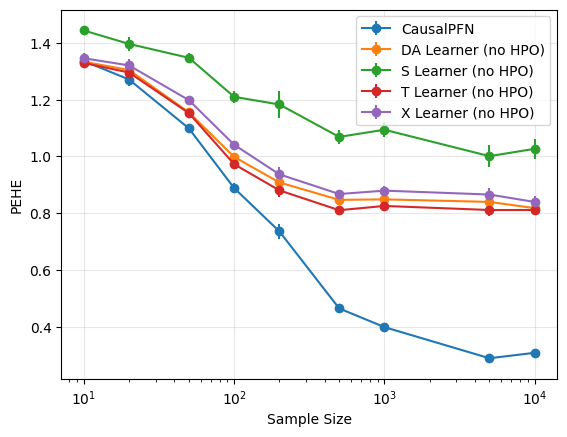

In [9]:
import matplotlib.pyplot as plt

# Calculate mean and std error
stats = results_df.groupby(["sample_size", "method"])["pehe"].agg(["mean", "sem"]).reset_index()

# Plot
plt.figure()
for method in stats["method"].unique():
    method_data = stats[stats["method"] == method]
    plt.errorbar(
        method_data["sample_size"],
        method_data["mean"],
        yerr=method_data["sem"],
        label=method,
        marker="o",
    )

plt.xlabel("Sample Size")
plt.ylabel("PEHE")
plt.xscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### The Effect of Feature Size on CausalPFN's Performance

In [10]:
import pandas as pd

methods_to_show = ["CausalPFN"] + list(baselines.keys())
results_df = pd.DataFrame(columns=["dataset", "method", "pehe", "realization"])
for dataset_name, dataset in feature_size_datasets.items():
    dset_result = load_all_results(dataset_name, feature_size_ablation_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["pehe"])
        for fold_idx in range(num_realizations):
            pehe = float(all_rows["pehe"][fold_idx])
            new_row = dict(
                dataset=dataset_name,
                method=method,
                pehe=pehe,
                realization=fold_idx,
            )
            results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

results_df["feature_size"] = results_df["dataset"].str.replace("polynomial_features_", "").astype(int)
results_df["dataset"] = None

In [11]:
# Group by method and feature_size, then calculate mean and standard error
summary_df = (
    results_df.groupby(["method", "feature_size"])["pehe"]
    .agg(["mean", "sem"])  # sem = standard error of the mean
    .reset_index()
)

# Format as "mean ± ste"
summary_df["mean_ste"] = summary_df.apply(lambda row: f"{row['mean']:.2f} ± {row['sem']:.2f}", axis=1)

# Pivot to get desired format
pivot_df = summary_df.pivot(index="method", columns="feature_size", values="mean_ste")

# Optional: sort columns numerically if needed
pivot_df = pivot_df.sort_index(axis=1)

pivot_df

feature_size,1,5,10,20,50,100,200,500,1000
method,,,,,,,,,
CausalPFN,0.08 ± 0.00,0.17 ± 0.01,0.40 ± 0.01,0.67 ± 0.01,0.87 ± 0.02,1.01 ± 0.02,1.17 ± 0.02,1.28 ± 0.02,1.32 ± 0.02
DA Learner (no HPO),0.21 ± 0.01,0.59 ± 0.01,0.85 ± 0.01,1.04 ± 0.01,1.14 ± 0.01,1.22 ± 0.01,1.25 ± 0.02,1.30 ± 0.02,1.32 ± 0.02
S Learner (no HPO),0.54 ± 0.04,0.83 ± 0.02,1.09 ± 0.02,1.17 ± 0.02,1.21 ± 0.02,1.23 ± 0.01,1.26 ± 0.02,1.30 ± 0.02,1.33 ± 0.02
T Learner (no HPO),0.27 ± 0.01,0.60 ± 0.01,0.83 ± 0.01,0.98 ± 0.01,1.09 ± 0.01,1.18 ± 0.01,1.23 ± 0.02,1.28 ± 0.02,1.32 ± 0.02
X Learner (no HPO),0.29 ± 0.01,0.64 ± 0.01,0.88 ± 0.01,1.06 ± 0.01,1.15 ± 0.01,1.23 ± 0.01,1.26 ± 0.02,1.30 ± 0.02,1.33 ± 0.02


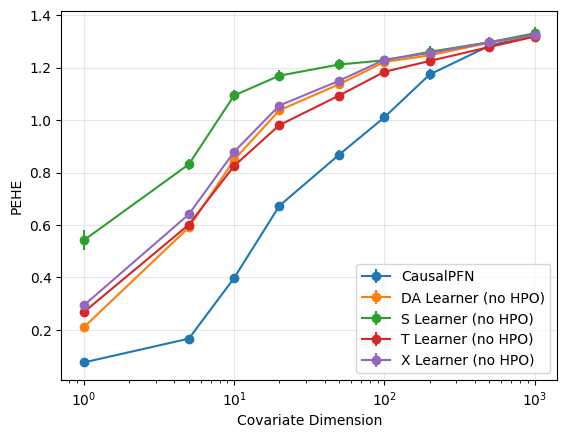

In [12]:
import matplotlib.pyplot as plt

# Calculate mean and std error
stats = results_df.groupby(["feature_size", "method"])["pehe"].agg(["mean", "sem"]).reset_index()

# Plot
plt.figure()
for method in stats["method"].unique():
    method_data = stats[stats["method"] == method]
    plt.errorbar(
        method_data["feature_size"],
        method_data["mean"],
        yerr=method_data["sem"],
        label=method,
        marker="o",
    )

plt.xlabel("Covariate Dimension")
plt.ylabel("PEHE")
plt.xscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## The Effect of Sample Size on the Length of Credible Intervals

### Run CausalPFN

In [13]:
from src.causalpfn import CATEEstimator
from causalpfn.evaluation import calculate_calibration_curve_scores

from tqdm import tqdm

credible_interval_ablation_path = os.path.join(os.environ["OUTPUT_DIR"], "ablation/credible_interval/")
os.makedirs(credible_interval_ablation_path, exist_ok=True)

n_bins = 10  # Number of bins for calibration curve

pbar = tqdm(
    total=sum([len(dataset) for dataset in sample_size_datasets.values()]),
    desc="CausalPFN",
)
for dataset_name, dataset in sample_size_datasets.items():
    pbar.set_postfix(dataset=dataset_name)
    for i in range(len(dataset)):
        with result_saver(
            dataset_name=dataset_name,
            method_name="CausalPFN",
            all_method_patterns="*",
            all_datasets_patterns="*",
            idx=i,
            artifact_dir=credible_interval_ablation_path,
            replace=replace_runs,
        ) as result:
            if result is not None:
                cate_dset, ate_dset = dataset[i]

                # CATE
                cate_estimator = CATEEstimator(
                    device=device,
                    calibrate=True,  # Enable calibration
                )
                cate_estimator.fit(cate_dset.X_train, cate_dset.t_train, cate_dset.y_train)
                _, ice = calculate_calibration_curve_scores(
                    fitted_estimator=cate_estimator,
                    X_test=cate_dset.X_test,
                    true_cate=cate_dset.true_cate,
                    n_bins=n_bins,
                )
                result["ice"] = ice

                inerval = cate_estimator.estimate_cate_CI(cate_dset.X_test, alpha=0.05)
                result["95_ci_length"] = (inerval["upper_bound"] - inerval["lower_bound"]).mean()

            pbar.update(1)
pbar.close()

CausalPFN: 100%|██████████| 450/450 [00:00<00:00, 5903.98it/s, dataset=polynomial_10000]


### Run DR Learner Baseline

In [14]:
from tqdm import tqdm
from benchmarks.baselines import ForestDRLearnerBaseline


baselines = {"Forest DR Learner (no HPO)": ForestDRLearnerBaseline(hpo=False)}


pbar = tqdm(
    total=sum([len(dataset) * len(baselines) for dataset in sample_size_datasets.values()]),
    desc="Baselines",
)

for dataset_name, dataset in sample_size_datasets.items():
    for baseline_name, baseline in baselines.items():
        pbar.set_postfix(dataset=dataset_name, baseline=baseline_name)
        for i in range(len(dataset)):
            with result_saver(
                dataset_name=dataset_name,
                method_name=baseline_name,
                all_method_patterns="*",
                all_datasets_patterns="*",
                idx=i,
                artifact_dir=credible_interval_ablation_path,
                replace=replace_runs,
            ) as result:
                if result is not None:
                    baseline: ForestDRLearnerBaseline
                    cate_dset, ate_dset = dataset[i]

                    # CATE
                    try:
                        interval = baseline.estimate_ci(
                            X_train=cate_dset.X_train,
                            t_train=cate_dset.t_train,
                            y_train=cate_dset.y_train,
                            X_test=cate_dset.X_test,
                            alpha=0.05,
                        )
                        result["95_ci_length"] = (interval[1] - interval[0]).mean()
                    except Exception as e:
                        print(e)
                        result["95_ci_length"] = None
                        continue

                pbar.update(1)
pbar.close()

Baselines: 100%|██████████| 450/450 [00:00<00:00, 6330.79it/s, baseline=Forest DR Learner (no HPO), dataset=polynomial_10000]


In [16]:
import pandas as pd

methods_to_show = ["CausalPFN"] + list(baselines.keys())
results_df = pd.DataFrame(columns=["dataset", "method", "ice", "ci_length_95", "realization"])
for dataset_name, dataset in sample_size_datasets.items():
    dset_result = load_all_results(dataset_name, credible_interval_ablation_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["95_ci_length"])
        for fold_idx in range(num_realizations):
            ice = float(all_rows["ice"][fold_idx]) if "ice" in all_rows else None
            ci_length_95 = float(all_rows["95_ci_length"][fold_idx])
            new_row = dict(
                dataset=dataset_name,
                method=method,
                ice=ice,
                ci_length_95=ci_length_95,
                realization=fold_idx,
            )
            results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

results_df["sample_size"] = results_df["dataset"].str.replace("polynomial_", "").astype(int)
results_df["dataset"] = None

In [17]:
# Group by method and sample_size, then calculate mean and standard error
summary_df = (
    results_df.groupby(["method", "sample_size"])[["ice", "ci_length_95"]]
    .agg(["mean", "sem"])  # sem = standard error of the mean
    .reset_index()
)

# Format as "mean ± ste"
summary_df["ice_mean_ste"] = summary_df.apply(lambda row: f"{row['ice']['mean']:.2f} ± {row['ice']['sem']:.2f}", axis=1)
summary_df["ci_length_95_mean_ste"] = summary_df.apply(
    lambda row: f"{row['ci_length_95']['mean']:.2f} ± {row['ci_length_95']['sem']:.2f}", axis=1
)

ice_df = summary_df.pivot(index="method", columns="sample_size", values="ice_mean_ste").query("method == 'CausalPFN'")

ice_df

sample_size,10,20,50,100,200,500,1000,5000,10000
method,,,,,,,,,
CausalPFN,0.13 ± 0.01,0.01 ± 0.01,0.01 ± 0.01,0.04 ± 0.00,0.02 ± 0.01,0.05 ± 0.00,0.03 ± 0.00,-0.01 ± 0.01,-0.04 ± 0.01


In [18]:
ci_df = summary_df.pivot(index="method", columns="sample_size", values="ci_length_95_mean_ste")

ci_df

sample_size,10,20,50,100,200,500,1000,5000,10000
method,,,,,,,,,
CausalPFN,12.67 ± 0.46,6.40 ± 0.33,4.74 ± 0.11,3.98 ± 0.08,2.98 ± 0.08,2.01 ± 0.04,1.67 ± 0.03,0.98 ± 0.04,0.97 ± 0.03
Forest DR Learner (no HPO),5.25 ± 0.68,2.49 ± 0.15,1.20 ± 0.03,0.83 ± 0.01,0.73 ± 0.02,0.69 ± 0.01,0.69 ± 0.01,0.58 ± 0.01,0.52 ± 0.01


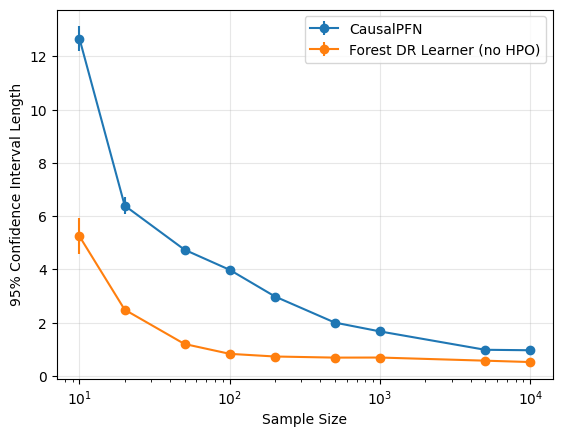

In [19]:
import matplotlib.pyplot as plt

# Calculate mean and std error
stats = results_df.groupby(["sample_size", "method"])["ci_length_95"].agg(["mean", "sem"]).reset_index()

# Plot
plt.figure()
for method in stats["method"].unique():
    method_data = stats[stats["method"] == method]
    plt.errorbar(
        method_data["sample_size"],
        method_data["mean"],
        yerr=method_data["sem"],
        label=method,
        marker="o",
    )

plt.xlabel("Sample Size")
plt.ylabel("95% Confidence Interval Length")
plt.xscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()